# **Analisis Prediksi Konsentrasi NO2 Menggunakan KNN Regression**

### **1. Pengambilan Data (Scraping)**

Data diambil dari sumber Dataspace Coneous yang menyediakan informasi cuaca dan kualitas udara. Scraping dilakukan untuk daerah **Surakarta** dan mengambil **periode 4 bulan penuh**, dengan mengambil variabel utama yaitu konsentrasi NO2 per hari.

Data mentah memiliki beberapa kolom, namun untuk keperluan analisis, hanya kolom NO2 dan tanggal (date) yang digunakan.

In [ ]:

import openeo
import pandas as pd
import matplotlib.pyplot as plt

# 1. Koneksi ke Copernicus Data Space
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.
0:00:00 Job 'j-25102307552043458de4cbce5b2f0d05': send 'start'
0:00:13 Job 'j-25102307552043458de4cbce5b2f0d05': created (progress 0%)
0:00:19 Job 'j-25102307552043458de4cbce5b2f0d05': created (progress 0%)
0:00:25 Job 'j-25102307552043458de4cbce5b2f0d05': created (progress 0%)
0:00:34 Job 'j-25102307552043458de4cbce5b2f0d05': created (progress 0%)
0:00:44 Job 'j-25102307552043458de4cbce5b2f0d05': created (progress 0%)
0:00:56 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:01:12 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:01:31 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:01:56 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:02:26 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:03:03 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:03:50 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:04:49 Job 'j-2510230755204345

/tmp/ipython-input-3794286045.py:67: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M")


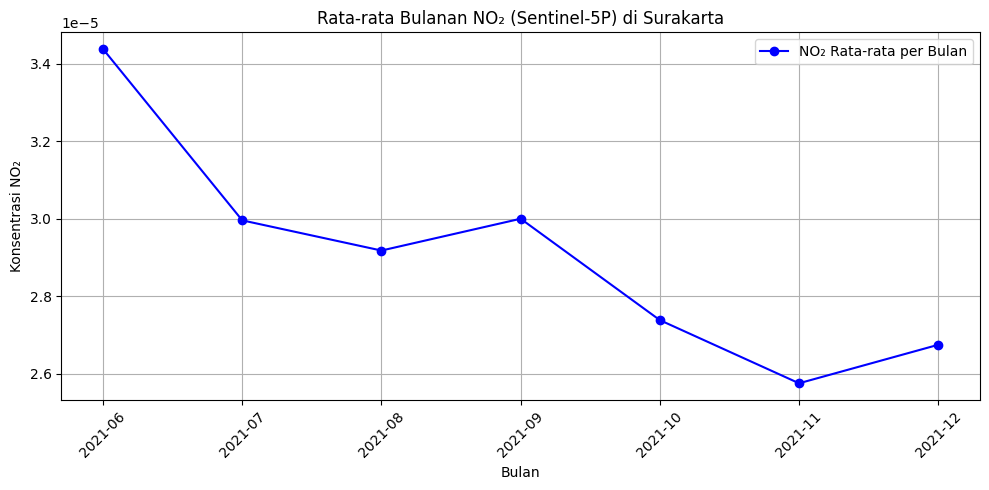

In [ ]:
import os
aoi = {
    "type": "Polygon",
    "coordinates": [
          [
            [110.73384843270605, -7.506125504050544],
            [110.73384843270605, -7.629910709610229],
            [110.93095130302544, -7.629910709610229],
            [110.93095130302544, -7.506125504050544],
            [110.73384843270605, -7.506125504050544]
          ]
        ],
}

s5p = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent = {
        "west": 110.73384843270605,
        "south": -7.629910709610229,
        "east": 110.93095130302544,
        "north": -7.506125504050544
    },
    temporal_extent=["2025-01-01", "2025-05-01"],
    bands=["NO2"],
)

def mask_invalid(x):
    return x < 0

s5p_masked = s5p.mask(s5p.apply(mask_invalid))

daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

job = daily_mean_aoi.execute_batch(out_format="CSV")

results = job.get_results()
results.download_files("data-copernicus")

for f in os.listdir("data-copernicus"):
    if f.endswith(".csv"):
        df = pd.read_csv(os.path.join("data-copernicus", f))
        print("File ditemukan:", f)
        break
    
df["date"] = pd.to_datetime(df["date"])

df["month"] = df["date"].dt.to_period("M")

df_monthly = df.groupby("month", as_index=False)["NO2"].mean()
df

In [ ]:
import pandas as pd

df = pd.read_csv('surakarta.csv')  
df["date"] = pd.to_datetime(df["date"])

df["month"] = df["date"].dt.to_period("M")

df_monthly = df.groupby("month", as_index=False)["NO2"].mean()
df

C:\Users\ARII\AppData\Local\Temp\ipykernel_3028\2757211628.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M")


date  feature_index       NO2    month
0   2025-04-02 00:00:00+00:00              0       NaN  2025-04
1   2025-03-30 00:00:00+00:00              0       NaN  2025-03
2   2025-04-05 00:00:00+00:00              0  0.000042  2025-04
3   2025-03-29 00:00:00+00:00              0       NaN  2025-03
4   2025-04-04 00:00:00+00:00              0  0.000011  2025-04
..                        ...            ...       ...      ...
116 2025-01-09 00:00:00+00:00              0  0.000040  2025-01
117 2025-01-15 00:00:00+00:00              0       NaN  2025-01
118 2025-01-11 00:00:00+00:00              0  0.000020  2025-01
119 2025-01-14 00:00:00+00:00              0       NaN  2025-01
120 2025-01-12 00:00:00+00:00              0       NaN  2025-01

[121 rows x 4 columns]

**Mengecek dataset**

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   date           121 non-null    datetime64[ns, UTC]
 1   feature_index  121 non-null    int64              
 2   NO2            45 non-null     float64            
 3   month          121 non-null    period[M]          
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), period[M](1)
memory usage: 3.9 KB
None


In [6]:
print(df.head())

                       date  feature_index       NO2    month
0 2025-04-02 00:00:00+00:00              0       NaN  2025-04
1 2025-03-30 00:00:00+00:00              0       NaN  2025-03
2 2025-04-05 00:00:00+00:00              0  0.000042  2025-04
3 2025-03-29 00:00:00+00:00              0       NaN  2025-03
4 2025-04-04 00:00:00+00:00              0  0.000011  2025-04


**Mengecek Jumlah Missing Value**

In [7]:
df.isnull().sum()


date              0
feature_index     0
NO2              76
month             0
dtype: int64

**Visualisasi misisng value**

C:\Users\ARII\AppData\Local\Temp\ipykernel_3028\2610598959.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, y + 0.5, f'{int(y)} ({p[i]:.1f}%)', ha='center', fontsize=9)


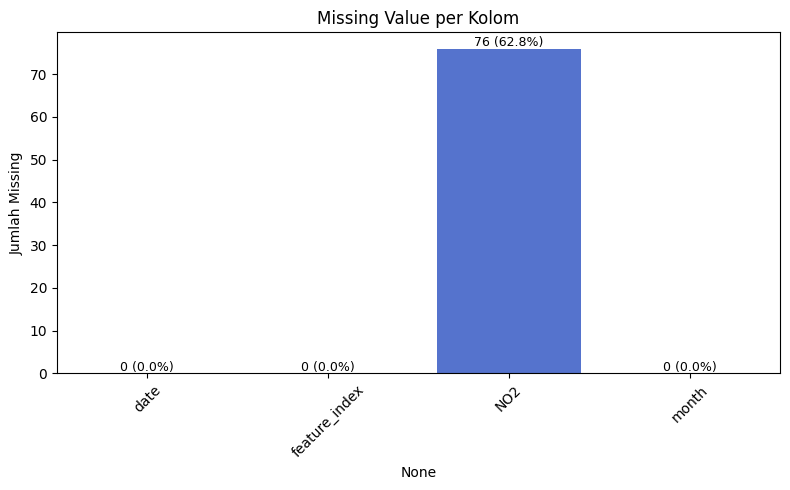

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

m = df.isnull().sum()
p = m / len(df) * 100

plt.figure(figsize=(8,5))
sns.barplot(x=m.index, y=m.values, color='royalblue')

for i, (x, y) in enumerate(zip(m.index, m.values)):
    plt.text(i, y + 0.5, f'{int(y)} ({p[i]:.1f}%)', ha='center', fontsize=9)

plt.title('Missing Value per Kolom')
plt.ylabel('Jumlah Missing')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### **3. Preprocessing Data NO2**

**a. Menangani Missing Values**

Pada dataset yang diunduh, ditemukan beberapa nilai hilang (missing values) di kolom NO2. Untuk menjaga kontinuitas data deret waktu (time series), nilai-nilai hilang diisi menggunakan metode interpolasi linear:

Metode ini memperkirakan nilai di antara dua titik data terdekat, menjaga kestabilan pola data.

In [9]:
print(df['NO2'].isna().sum())

76


In [10]:
df['NO2'] = df['NO2'].interpolate(method='linear')

In [11]:
print(df['NO2'].isna().sum())
df[df['NO2'].isna()]

2


date  feature_index  NO2    month
0 2025-04-02 00:00:00+00:00              0  NaN  2025-04
1 2025-03-30 00:00:00+00:00              0  NaN  2025-03

In [12]:
df['NO2'] = df['NO2'].interpolate(method='linear').bfill()

In [13]:
print(df['NO2'].isna().sum())

0


### **4. Pembentukan Data Supervised**
Karena data NO2 bersifat deret waktu, maka dibentuk data supervised untuk memprediksi nilai ke depan berdasarkan beberapa nilai sebelumnya.

Tiga eksperimen dilakukan dengan variasi jumlah lag:

- Eksperimen 1: Menggunakan 3 lag (NO2-t3, NO2-t2, NO2-t1, NO2)
- Eksperimen 2: Menggunakan 4 lag (NO2-t4, NO2-t3, NO2-t2, NO2-t1, NO2)
- Eksperimen 3: Menggunakan 5 lag (NO2-t5, NO2-t4, NO2-t3, NO2-t2, NO2-t1, NO2)

Tujuannya adalah untuk melihat pengaruh jumlah lag terhadap performa model.

In [14]:
import pandas as pd

def make_supervised(df, target_col='NO2', n_lags=3):
    """
    Membuat dataset supervised learning dengan lag features.

    Parameters:
      df : DataFrame dengan kolom target (misal 'NO2')
      target_col : nama kolom target
      n_lags : jumlah lag yang ingin digunakan (misal 3 → t-1, t-2, t-3)

    Returns:
      DataFrame baru dengan kolom lag + target (tanpa NaN)
    """
    df_supervised = df.copy()
    # Buat kolom lag
    for i in range(1, n_lags + 1):
        df_supervised[f'{target_col}_t-{i}'] = df_supervised[target_col].shift(i)

    # Urutkan kolom biar rapi (lag dulu, target terakhir)
    cols = [f'{target_col}_t-{i}' for i in range(n_lags, 0, -1)] + [target_col]
    df_supervised = df_supervised[cols]

    # Hapus baris dengan NaN (karena hasil shift)
    df_supervised = df_supervised.dropna().reset_index(drop=True)

    return df_supervised

In [15]:
# Pastikan df hanya punya kolom NO2
df = df[['NO2']].copy().reset_index(drop=True)

# Eksperimen 1: 3 lag
df_exp1 = make_supervised(df, n_lags=3)
print("Eksperimen 1 (3 lag):")
print(df_exp1.head(), "\n")

# Eksperimen 2: 4 lag
df_exp2 = make_supervised(df, n_lags=4)
print("Eksperimen 2 (4 lag):")
print(df_exp2.head(), "\n")

# Eksperimen 3: 5 lag
df_exp3 = make_supervised(df, n_lags=5)
print("Eksperimen 3 (5 lag):")
print(df_exp3.head(), "\n")

Eksperimen 1 (3 lag):
    NO2_t-3   NO2_t-2   NO2_t-1       NO2
0  0.000042  0.000042  0.000042  0.000027
1  0.000042  0.000042  0.000027  0.000011
2  0.000042  0.000027  0.000011  0.000016
3  0.000027  0.000011  0.000016  0.000018
4  0.000011  0.000016  0.000018  0.000020 

Eksperimen 2 (4 lag):
    NO2_t-4   NO2_t-3   NO2_t-2   NO2_t-1       NO2
0  0.000042  0.000042  0.000042  0.000027  0.000011
1  0.000042  0.000042  0.000027  0.000011  0.000016
2  0.000042  0.000027  0.000011  0.000016  0.000018
3  0.000027  0.000011  0.000016  0.000018  0.000020
4  0.000011  0.000016  0.000018  0.000020  0.000022 

Eksperimen 3 (5 lag):
    NO2_t-5   NO2_t-4   NO2_t-3   NO2_t-2   NO2_t-1       NO2
0  0.000042  0.000042  0.000042  0.000027  0.000011  0.000016
1  0.000042  0.000042  0.000027  0.000011  0.000016  0.000018
2  0.000042  0.000027  0.000011  0.000016  0.000018  0.000020
3  0.000027  0.000011  0.000016  0.000018  0.000020  0.000022
4  0.000011  0.000016  0.000018  0.000020  0.000022  0.0

In [16]:
print(len(df_exp1))
print(len(df_exp2))
print(len(df_exp3))


118
117
116


In [17]:
# Simpan ke file CSV
df_exp1.to_csv('supervised_lag1.csv', index=False)
df_exp2.to_csv('supervised_lag2.csv', index=False)
df_exp3.to_csv('supervised_lag3.csv', index=False)

print("Semua dataset supervised sudah disimpan sebagai file CSV.")


Semua dataset supervised sudah disimpan sebagai file CSV.


### **5. Pembangunan Model KNN Regression**

Untuk setiap eksperimen, digunakan model KNN Regressor dari scikit-learn dengan parameter n_neighbors=3. Model dilatih dengan pembagian data train-test split 80:20 tanpa shuffle karena bersifat time series.

Proses pelatihan dan evaluasi:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

**Baca file CSV**

In [ ]:
df_exp1 = pd.read_csv('supervised_lag1.csv')
df_exp2 = pd.read_csv('supervised_lag2.csv')
df_exp3 = pd.read_csv('supervised_lag3.csv')


In [6]:
df_exp1

NO2_t-3   NO2_t-2   NO2_t-1       NO2
0    0.000042  0.000042  0.000042  0.000027
1    0.000042  0.000042  0.000027  0.000011
2    0.000042  0.000027  0.000011  0.000016
3    0.000027  0.000011  0.000016  0.000018
4    0.000011  0.000016  0.000018  0.000020
..        ...       ...       ...       ...
113  0.000028  0.000032  0.000036  0.000040
114  0.000032  0.000036  0.000040  0.000030
115  0.000036  0.000040  0.000030  0.000020
116  0.000040  0.000030  0.000020  0.000020
117  0.000030  0.000020  0.000020  0.000020

[118 rows x 4 columns]

In [7]:
df_exp2

NO2_t-4   NO2_t-3   NO2_t-2   NO2_t-1       NO2
0    0.000042  0.000042  0.000042  0.000027  0.000011
1    0.000042  0.000042  0.000027  0.000011  0.000016
2    0.000042  0.000027  0.000011  0.000016  0.000018
3    0.000027  0.000011  0.000016  0.000018  0.000020
4    0.000011  0.000016  0.000018  0.000020  0.000022
..        ...       ...       ...       ...       ...
112  0.000024  0.000028  0.000032  0.000036  0.000040
113  0.000028  0.000032  0.000036  0.000040  0.000030
114  0.000032  0.000036  0.000040  0.000030  0.000020
115  0.000036  0.000040  0.000030  0.000020  0.000020
116  0.000040  0.000030  0.000020  0.000020  0.000020

[117 rows x 5 columns]

In [8]:
df_exp3

NO2_t-5   NO2_t-4   NO2_t-3   NO2_t-2   NO2_t-1       NO2
0    0.000042  0.000042  0.000042  0.000027  0.000011  0.000016
1    0.000042  0.000042  0.000027  0.000011  0.000016  0.000018
2    0.000042  0.000027  0.000011  0.000016  0.000018  0.000020
3    0.000027  0.000011  0.000016  0.000018  0.000020  0.000022
4    0.000011  0.000016  0.000018  0.000020  0.000022  0.000046
..        ...       ...       ...       ...       ...       ...
111  0.000024  0.000024  0.000028  0.000032  0.000036  0.000040
112  0.000024  0.000028  0.000032  0.000036  0.000040  0.000030
113  0.000028  0.000032  0.000036  0.000040  0.000030  0.000020
114  0.000032  0.000036  0.000040  0.000030  0.000020  0.000020
115  0.000036  0.000040  0.000030  0.000020  0.000020  0.000020

[116 rows x 6 columns]

**modeling t3**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

data_path = 'supervised_lag1.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['NO2'])
y = df['NO2']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan min-max untuk referensi
min_values = scaler.data_min_
max_values = scaler.data_max_

print("\n📊 Nilai Min-Max fitur:")
for col, minv, maxv in zip(X.columns, min_values, max_values):
    print(f"{col:10s} → Min: {minv:.8f} | Max: {maxv:.8f}")

k = 12
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = r2_score(y_test, y_pred)

print("\n=== HASIL EVALUASI MODEL KNN ===")
print(f"File Data      : {data_path}")
print(f"Jumlah Data    : {len(df)} (Train: {len(X_train)}, Test: {len(X_test)})")
print(f"k (neighbors)  : {k}")
print(f"RMSE           : {rmse:.8f}")
print(f"MAE            : {mae:.8f}")
print(f"MAPE           : {mape:.2f}%")
print(f"R² Score       : {r2:.4f}")

output_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})
output_name = f"result_{data_path.split('.')[0]}.csv"
output_df.to_csv(output_name, index=False)

print(f"\n✅ Hasil prediksi disimpan ke: {output_name}")

scaler_df = pd.DataFrame({'Feature': X.columns, 'Min': min_values, 'Max': max_values})
scaler_file = f"scaler_params_{data_path.split('.')[0]}.csv"
scaler_df.to_csv(scaler_file, index=False)
print(f"✅ Parameter Min-Max disimpan ke: {scaler_file}")



📊 Nilai Min-Max fitur:
NO2_t-3    → Min: 0.00001091 | Max: 0.00005871
NO2_t-2    → Min: 0.00001091 | Max: 0.00005871
NO2_t-1    → Min: 0.00001091 | Max: 0.00005871

=== HASIL EVALUASI MODEL KNN ===
File Data      : supervised_lag1.csv
Jumlah Data    : 118 (Train: 94, Test: 24)
k (neighbors)  : 12
RMSE           : 0.00000381
MAE            : 0.00000304
MAPE           : 10.50%
R² Score       : 0.5889

✅ Hasil prediksi disimpan ke: result_supervised_lag1.csv
✅ Parameter Min-Max disimpan ke: scaler_params_supervised_lag1.csv


In [14]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

print("\n=== Data Training (Setelah Normalisasi) ===")
print(X_train_scaled_df.head())

print("\n=== Data Testing (Setelah Normalisasi) ===")
print(X_test_scaled_df.head())


=== Data Training (Setelah Normalisasi) ===
    NO2_t-3   NO2_t-2   NO2_t-1
0  0.653287  0.653287  0.653287
1  0.653287  0.653287  0.326644
2  0.653287  0.326644  0.000000
3  0.326644  0.000000  0.096733
4  0.000000  0.096733  0.140227

=== Data Testing (Setelah Normalisasi) ===
    NO2_t-3   NO2_t-2   NO2_t-1
0  0.185797  0.254637  0.304790
1  0.254637  0.304790  0.354943
2  0.304790  0.354943  0.405095
3  0.354943  0.405095  0.455248
4  0.405095  0.455248  0.505401


**modeling t4**

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

data_path = 'supervised_lag2.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['NO2'])
y = df['NO2']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan min-max untuk referensi
min_values = scaler.data_min_
max_values = scaler.data_max_

print("\n📊 Nilai Min-Max fitur:")
print("\n📊 Nilai Min-Max fitur:")
for col, minv, maxv in zip(X.columns, min_values, max_values):
    print(f"{col:10s} → Min: {minv:.8f} | Max: {maxv:.8f}")

k = 13
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = r2_score(y_test, y_pred)

print("\n=== HASIL EVALUASI MODEL KNN ===")
print(f"File Data      : {data_path}")
print(f"Jumlah Data    : {len(df)} (Train: {len(X_train)}, Test: {len(X_test)})")
print(f"k (neighbors)  : {k}")
print(f"RMSE           : {rmse:.8f}")
print(f"MAE            : {mae:.8f}")
print(f"MAPE           : {mape:.2f}%")
print(f"R² Score       : {r2:.4f}")

output_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})
output_name = f"result_{data_path.split('.')[0]}.csv"
output_df.to_csv(output_name, index=False)

print(f"\n✅ Hasil prediksi disimpan ke: {output_name}")

scaler_df = pd.DataFrame({'Feature': X.columns, 'Min': min_values, 'Max': max_values})
scaler_file = f"scaler_params_{data_path.split('.')[0]}.csv"
scaler_df.to_csv(scaler_file, index=False)
print(f"✅ Parameter Min-Max disimpan ke: {scaler_file}")



📊 Nilai Min-Max fitur:

📊 Nilai Min-Max fitur:
NO2_t-4    → Min: 0.00001091 | Max: 0.00005871
NO2_t-3    → Min: 0.00001091 | Max: 0.00005871
NO2_t-2    → Min: 0.00001091 | Max: 0.00005871
NO2_t-1    → Min: 0.00001091 | Max: 0.00005871

=== HASIL EVALUASI MODEL KNN ===
File Data      : supervised_lag2.csv
Jumlah Data    : 117 (Train: 93, Test: 24)
k (neighbors)  : 13
RMSE           : 0.00000430
MAE            : 0.00000334
MAPE           : 11.66%
R² Score       : 0.4766

✅ Hasil prediksi disimpan ke: result_supervised_lag2.csv
✅ Parameter Min-Max disimpan ke: scaler_params_supervised_lag2.csv


In [18]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

print("\n=== Data Training (Setelah Normalisasi) ===")
print(X_train_scaled_df.head())

print("\n=== Data Testing (Setelah Normalisasi) ===")
print(X_test_scaled_df.head())



=== Data Training (Setelah Normalisasi) ===
    NO2_t-4   NO2_t-3   NO2_t-2   NO2_t-1
0  0.653287  0.653287  0.653287  0.326644
1  0.653287  0.653287  0.326644  0.000000
2  0.653287  0.326644  0.000000  0.096733
3  0.326644  0.000000  0.096733  0.140227
4  0.000000  0.096733  0.140227  0.183720

=== Data Testing (Setelah Normalisasi) ===
    NO2_t-4   NO2_t-3   NO2_t-2   NO2_t-1
0  0.123395  0.185797  0.254637  0.304790
1  0.185797  0.254637  0.304790  0.354943
2  0.254637  0.304790  0.354943  0.405095
3  0.304790  0.354943  0.405095  0.455248
4  0.354943  0.405095  0.455248  0.505401


**modeling t5**

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

data_path = 'supervised_lag3.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['NO2'])
y = df['NO2']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan min-max untuk referensi
min_values = scaler.data_min_
max_values = scaler.data_max_

print("\n📊 Nilai Min-Max fitur:")
for col, minv, maxv in zip(X.columns, min_values, max_values):
    print(f"{col:10s} → Min: {minv:.8f} | Max: {maxv:.8f}")

k = 13
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = r2_score(y_test, y_pred)

print("\n=== HASIL EVALUASI MODEL KNN ===")
print(f"File Data      : {data_path}")
print(f"Jumlah Data    : {len(df)} (Train: {len(X_train)}, Test: {len(X_test)})")
print(f"k (neighbors)  : {k}")
print(f"RMSE           : {rmse:.8f}")
print(f"MAE            : {mae:.8f}")
print(f"MAPE           : {mape:.2f}%")
print(f"R² Score       : {r2:.4f}")

output_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})
output_name = f"result_{data_path.split('.')[0]}.csv"
output_df.to_csv(output_name, index=False)

print(f"\n✅ Hasil prediksi disimpan ke: {output_name}")

scaler_df = pd.DataFrame({'Feature': X.columns, 'Min': min_values, 'Max': max_values})
scaler_file = f"scaler_params_{data_path.split('.')[0]}.csv"
scaler_df.to_csv(scaler_file, index=False)
print(f"✅ Parameter Min-Max disimpan ke: {scaler_file}")



📊 Nilai Min-Max fitur:
NO2_t-5    → Min: 0.00001091 | Max: 0.00005871
NO2_t-4    → Min: 0.00001091 | Max: 0.00005871
NO2_t-3    → Min: 0.00001091 | Max: 0.00005871
NO2_t-2    → Min: 0.00001091 | Max: 0.00005871
NO2_t-1    → Min: 0.00001091 | Max: 0.00005871

=== HASIL EVALUASI MODEL KNN ===
File Data      : supervised_lag3.csv
Jumlah Data    : 116 (Train: 92, Test: 24)
k (neighbors)  : 13
RMSE           : 0.00000482
MAE            : 0.00000384
MAPE           : 13.57%
R² Score       : 0.3424

✅ Hasil prediksi disimpan ke: result_supervised_lag3.csv
✅ Parameter Min-Max disimpan ke: scaler_params_supervised_lag3.csv


In [21]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

print("\n=== Data Training (Setelah Normalisasi) ===")
print(X_train_scaled_df.head())

print("\n=== Data Testing (Setelah Normalisasi) ===")
print(X_test_scaled_df.head())


=== Data Training (Setelah Normalisasi) ===
    NO2_t-5   NO2_t-4   NO2_t-3   NO2_t-2   NO2_t-1
0  0.653287  0.653287  0.653287  0.326644  0.000000
1  0.653287  0.653287  0.326644  0.000000  0.096733
2  0.653287  0.326644  0.000000  0.096733  0.140227
3  0.326644  0.000000  0.096733  0.140227  0.183720
4  0.000000  0.096733  0.140227  0.183720  0.227214

=== Data Testing (Setelah Normalisasi) ===
    NO2_t-5   NO2_t-4   NO2_t-3   NO2_t-2   NO2_t-1
0  0.304439  0.123395  0.185797  0.254637  0.304790
1  0.123395  0.185797  0.254637  0.304790  0.354943
2  0.185797  0.254637  0.304790  0.354943  0.405095
3  0.254637  0.304790  0.354943  0.405095  0.455248
4  0.304790  0.354943  0.405095  0.455248  0.505401



=== 3 Lag ===
RMSE : 0.0000
MAE  : 0.0000
MAPE : 11.13%
R²   : 0.5655

=== 4 Lag ===
RMSE : 0.0000
MAE  : 0.0000
MAPE : 11.66%
R²   : 0.4766

=== 5 Lag ===
RMSE : 0.0000
MAE  : 0.0000
MAPE : 13.57%
R²   : 0.3424

=== SUMMARY HASIL EKSPERIMEN ===
  Eksperimen      RMSE       MAE       MAPE        R²
0      3 Lag  0.000004  0.000003  11.130540  0.565454
1      4 Lag  0.000004  0.000003  11.660418  0.476622
2      5 Lag  0.000005  0.000004  13.567054  0.342411

✅ Model terbaik: 3 Lag → R² = 0.5655


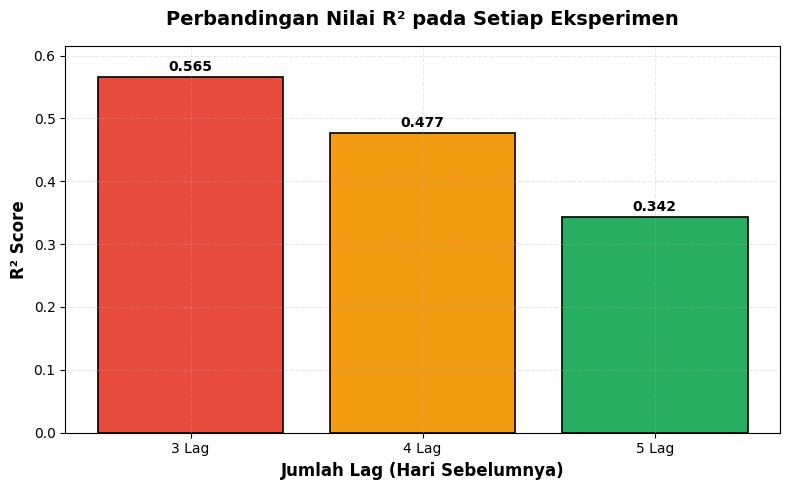

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

files = [
    ('3 Lag', 'supervised_lag1.csv'),
    ('4 Lag', 'supervised_lag2.csv'),
    ('5 Lag', 'supervised_lag3.csv')
]

# Simpan hasil evaluasi
results = []
for name, file_path in files:
    print(f"\n=== {name} ===")

    # 1️⃣ Baca dataset
    df = pd.read_csv(file_path)
    X = df.drop(columns=['NO2'])
    y = df['NO2']

    # 2️⃣ Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # 3️⃣ Normalisasi (MinMax berdasarkan training)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 4️⃣ Modeling KNN
    k = 13
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)

    # 5️⃣ Evaluasi
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"R²   : {r2:.4f}")

    # Simpan hasil
    results.append({'Eksperimen': name, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R²': r2})

results_df = pd.DataFrame(results)
print("\n=== SUMMARY HASIL EKSPERIMEN ===")
print(results_df)

best_idx = results_df['R²'].idxmax()
best_model = results_df.loc[best_idx]
print(f"\n✅ Model terbaik: {best_model['Eksperimen']} → R² = {best_model['R²']:.4f}")

x = results_df['Eksperimen']
y = results_df['R²']

colors = ['#E74C3C', '#F39C12', '#27AE60']

plt.figure(figsize=(8,5))
bars = plt.bar(x, y, color=colors, edgecolor='black', linewidth=1.2)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{y[i]:.3f}', ha='center', va='bottom',
             fontweight='bold', fontsize=10)

plt.title('Perbandingan Nilai R² pada Setiap Eksperimen', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Jumlah Lag (Hari Sebelumnya)', fontsize=12, fontweight='bold')
plt.ylabel('R² Score', fontsize=12, fontweight='bold')
plt.ylim(0, max(y) + 0.05)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



=== Plotting 3 Lag ===


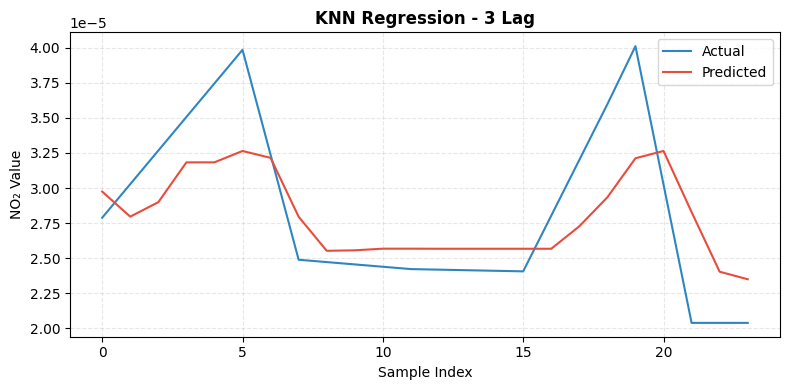


=== Plotting 4 Lag ===


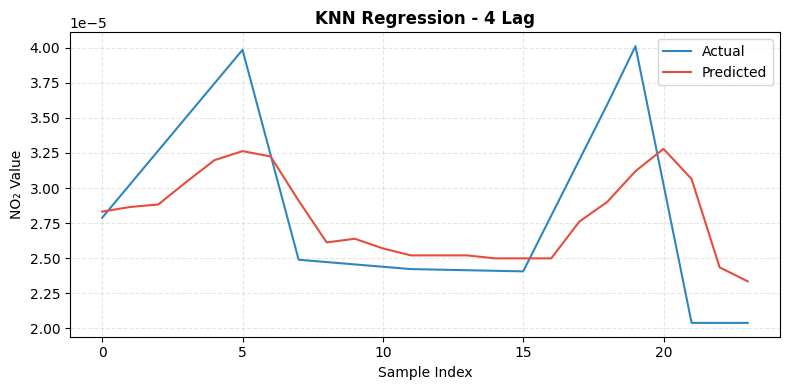


=== Plotting 5 Lag ===


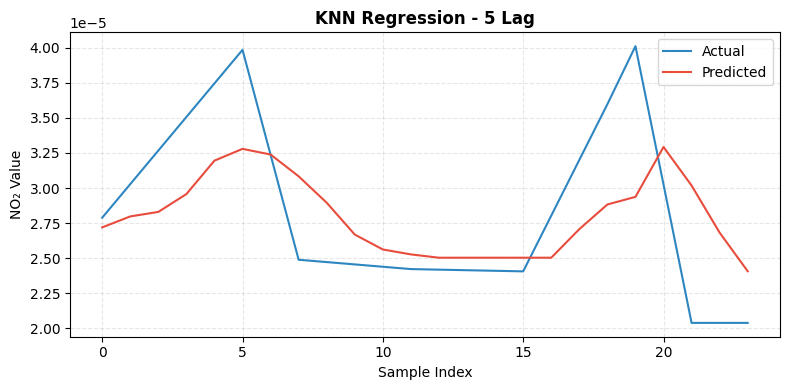

In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

for name, file_path in files:
    print(f"\n=== Plotting {name} ===")

    # 1️⃣ Load dataset
    df = pd.read_csv(file_path)
    X = df.drop(columns=['NO2'])
    y = df['NO2']

    # 2️⃣ Split (tanpa shuffle agar urutannya tetap)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # 3️⃣ Normalisasi berdasarkan data training
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 4️⃣ Model KNN
    knn = KNeighborsRegressor(n_neighbors=13)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)

    # 5️⃣ Plot Actual vs Predicted
    plt.figure(figsize=(8, 4))
    plt.plot(np.arange(len(y_test)), y_test, label="Actual", color="#2E86C1")
    plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted", color="#E74C3C")
    plt.title(f"KNN Regression - {name}", fontsize=12, fontweight='bold')
    plt.xlabel("Sample Index", fontsize=10)
    plt.ylabel("NO₂ Value", fontsize=10)
    plt.legend()
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
